In [1]:
class node:
    # Properties: name
    def __init__(self, name):
        self.name = name

    def __str__(self):
        return("NODE_"+self.name)

    def __eq__(self, other):
        return(str(self) == str(other))

    def __hash__(self):
        return(str(self).__hash__())

In [2]:
class edge:
    # Properties: name, leftNode, rightNode, directed(True/False)
    # Functions: getNodes(): List of 2 nodes. In the order [from, to]
    #            isDirected(): True/False
    def __init__(self, leftNode, rightNode, name="", directed=False):
        self.directed = directed
        self.leftNode = leftNode
        self.rightNode = rightNode
        self.name = name
        
    def __str__(self):
        if self.directed:
            return("EDGE_{}_({})->({})".format(self.name,
                                               self.leftNode.name,
                                               self.rightNode.name))
        else:
            return("EDGE_{}_({})--({})".format(self.name,
                                               self.leftNode.name,
                                               self.rightNode.name))

    def getNodes(self):
        return([self.leftNode, self.rightNode])

    def isDirected(self):
        return(self.directed)

In [64]:
class graph:
    # Properties: nodes[], edges[]
    # Functions:
    # getSubGraph(node, depth):
    #   returns a subgraph by following the edges
    #   to a depth of 'depth'
    # getNodes(filter): return all nodes that satisfy the filter.
    #   If no filter given, return all nodes
    # getEdges(filter): return all edges that satisfy the filter.
    #   If no filter given, return all nodes
    # make(): form a dictionary of nodes to access quickly
    def __init__(self, nodes, edges):
        self.nodes = nodes
        self.edges = edges
        self.make()
        
    def getNodes(self, f):
        returningNodes = []
        for node in self.nodes:
            if f(node):
                returningNodes.append(node)
        return(returningNodes)

    def getEdges(self, f):
        returningEdges = []
        for edge in self.edges:
            if f(edge):
                returningEdges.append(edge)
        return(returningEdges)

    def make(self):
        # Turn the nodes and edges list into an adjacency list.
        # Format: {node1 : [(edge1, node2), (edge2, node3),...], ...}
        self.graphDict = dict()
        for node in self.nodes:
            self.graphDict[node] = []
        for edge in self.edges:
            leftNode, rightNode = edge.getNodes()
            if edge.isDirected():
                # If the edge is directed,
                # just add leftNode -> (edge, rightNode)
                self.graphDict[leftNode].append((edge, rightNode))
            else:
                # Else, both leftNode -> (edge, rightNode)
                # and rightNode -> (edge, leftNode)
                self.graphDict[leftNode].append((edge, rightNode))
                self.graphDict[rightNode].append((edge, leftNode))
    
    def getSubGraph(self, node, depth=1):
        
        def collapsed(lst):
            temp = []

            def collapseList(l):
                for ele in l:
                    if isinstance(ele, list):
                        # i.e., if the element is a list
                        collapseList(ele)
                    else:
                        temp.append(ele)

            collapseList(lst)
            return(temp)
        
        # Follow the edges and return a connected subGraph
        nodesOfSG = [[node]]
        edgesOfSG = []
        for i in range(depth):
            localNodes = []
            localEdges = []
            # print(list(map(lambda x: str(x), nodesOfSG[-1])))
            for node in collapsed(nodesOfSG[-1]):
                # nodesOfSG[-1] will refer to the last list of (list of nodes)
                # found at the distance i from starting node
                # nodesOfSG[-1] = [[nodes reached by n1] [nodes reached by n2]
                # where n1,n2,... are nodes found at distance i-1 from starting node
                l = self.graphDict[node]
                # append only if we found atleast one node
                if len(l) > 0:
                    localNodes.append(list(map(lambda x: x[1], l)))
                    localEdges.append(list(map(lambda x: x[0], l)))
            # if we found nothing at this distance, there's no way to go one step further
            if len(localNodes) == 0:
                break
            nodesOfSG.append(localNodes)
            edgesOfSG.append(localEdges)
        
        return graph(collapsed(nodesOfSG), collapsed(edgesOfSG))

In [65]:
class state(node):
    def __init__(self, name, isInitState=False, isFinalState=False):
        super().__init__(name)
        self.isInitState = isInitState
        self.isFinalState = isFinalState

    def setInitState(self, isInitState):
        self.isInitState = isInitState

    def setFinalState(self, isFinalState):
        self.isFinalState = isFinalState

    def __str__(self):
        return("State_"+self.name
               + "_i-"+str(self.isInitState)
               + "_f-"+str(self.isFinalState))

    def __eq__(self, other):
        return(self.name == other.name
               and self.isInitState == other.isInitState
               and self.isFinalState == other.isFinalState)

    def __hash__(self):
        return(str(self).__hash__())

In [66]:
class transition(edge):
    def __init__(self, leftState, rightState, symbol, name=""):
        super().__init__(leftState, rightState, "", True)
        self.symbol = symbol

In [82]:
class FSM(graph):
    def __init__(self, states, transitions):
        super().__init__(states, transitions)
        self.initState = [s for s in states if s.isInitState][0]
        self.finalStates = [f for f in states if f.isFinalState]

    def run(self, s):
        currentState = self.initState
        for symbol in s:
            sub = self.getSubGraph(currentState)
            trans = sub.getEdges(lambda x: x.symbol == symbol)[0]
            currentState = trans.getNodes()[1]
        return(currentState in self.finalStates)
    
    def minimize(self):
        # returns a minimized FSM
        # Make a copy of this FSM called COPY
        # First, make a list of nodes, each node representing
        #   a pair of nodes. Name: "indexOfNode1 indexOfNode2"
        # For each pair (each node), create an edge to the pair
        #   of nodes it goes to on a 0, and the pair it goes to on
        #   a 1.
        # Next, mark (add to distinguished list) recursively all nodes which have a connection
        #  to those pairs with 1 final and 1 non-final nodes
        # For each unmarked (indistinguishable) pair (say EF)
        #  make all the edges that go to F to go to E (rename E as EF)
        #  and delete node F in COPY
        # Return COPY
        import copy as cp
        dupl = cp.deepcopy(self)
        pairs = []
        pedges = []
        # we take only unique pairs (for example, if we take 12, we ignore 21)
        # as they are the same pair
        # But we do take pairs of same node (11, 22, etc) as a pair of nodes can go
        # to the same node on 0 and/or 1
        for i in range(len(self.nodes)):
            for j in range(i,len(self.nodes)):
                # the pair is, for example '2 3', which means its a pair of
                # node 2 and node 3. X means it is distinguishible (marked)
                pairs.append(node(str(i)+" "+str(j)))
        for p in pairs:
            n1 = dupl.nodes[int(p.name.split()[0])]
            n2 = dupl.nodes[int(p.name.split()[1])]
            n1sg = dupl.getSubGraph(n1)
            n2sg = dupl.getSubGraph(n2)
            n1on0 = n1sg.getEdges(lambda e: e.symbol == '0')[0].rightNode
            n1on1 = n1sg.getEdges(lambda e: e.symbol == '1')[0].rightNode
            n2on0 = n2sg.getEdges(lambda e: e.symbol == '0')[0].rightNode
            n2on1 = n2sg.getEdges(lambda e: e.symbol == '1')[0].rightNode
            n1on0index = self.nodes.index(n1on0)
            n2on0index = self.nodes.index(n2on0)
            n1on1index = self.nodes.index(n1on1)
            n2on1index = self.nodes.index(n2on1)
            # if n1, n2 are 2,1, make them 1,2
            if n1on0index > n2on0index:
                n1on0index, n2on0index = n2on0index, n1on0index
            if n1on1index > n2on1index:
                n1on1index, n2on1index = n2on1index, n1on1index
            # pairs are of the form:
            #  00 01 02 03 11 12 13 22 23 33
            # therefore, pair ij has index n+(n-1)+(n-2)+... (i termse) + (j-i)
            # which reduces to, n*i + i(i-1)/2 + (j-i)
            pairIndexon0 = n1on0index*len(self.nodes)-int((n1on0index)*(n1on0index-1)/2)+n2on0index-n1on0index
            pairIndexon1 = n1on1index*len(self.nodes)-int((n1on1index)*(n1on1index-1)/2)+n2on1index-n1on1index
            # note: edges are directed in reverse. This is to help in recursive marking
            pedges.append(edge(pairs[pairIndexon0], p, "", True))
            pedges.append(edge(pairs[pairIndexon1], p, "", True))
        pairGraph = graph(pairs, pedges)
        print("Nodes of pair graph:")
        print(list(map(lambda x: str(x), pairGraph.nodes)))
        print("Edges of pair graph: ")
        print(list(map(lambda x: str(x), pairGraph.edges)))
        distinguished = []
        for p in pairGraph.getNodes(lambda x: x):
            # If p is distinguishable, get subgraph of pairGraph from p,
            #  upto distance of len(edges)
            #  mark all the nodes in this subgraph
            ln = dupl.nodes[int(p.name.split()[0])]
            rn = dupl.nodes[int(p.name.split()[1])]
            if not (ln.isFinalState == rn.isFinalState):
                # print(str(ln)+" and "+str(rn)+ " are distinguishable")
                sg = pairGraph.getSubGraph(p, len(pedges))
                for n in sg.getNodes(lambda x: x):
                    distinguished.append(n)
        indistinguishables = [n for n in pairs if not (n in distinguished)]
        nodestobeDeleted = []
        edgestobeDeleted = []
        for i in indistinguishables:
            n1 = dupl.nodes[int(i.name.split()[0])]
            n2 = dupl.nodes[int(i.name.split()[1])]
            if n1 == n2:
                continue
            # take all edges that go to n2 in copy
            edgeston2 = dupl.getEdges(lambda e: e.rightNode == n2)
            for e in edgeston2:
                e.rightNode = n1
            nodestobeDeleted.append(n2)
            edgestobeDeleted.append(dupl.getSubGraph(n2,1).getEdges(lambda x: x)[0])
            edgestobeDeleted.append(dupl.getSubGraph(n2,1).getEdges(lambda x: x)[1])
        for nd in nodestobeDeleted:
            if nd in dupl.nodes:
                dupl.nodes.remove(nd)
        for ed in edgestobeDeleted:
            if ed in dupl.edges:
                dupl.edges.remove(ed)
        dupl.finalStates = [f for f in dupl.nodes if f.isFinalState]
        dupl.make()
        return(dupl)

    def display(self):
        import matplotlib.pyplot as plt
        import math
        import random
        import numpy as np
        
        ns = len(self.nodes)    # Number of states
        # To arrange n nodes of radius r on the circumference of a large circle
        # of radius R, 2(pi)R = 2n(2r) => r = R(pi)/2n
        rs = math.pi/(2*ns)    # R is 1

        colors = [(random.random(), random.random(), random.random())
                  for state in self.nodes]
        theta = 0
        for state in self.nodes:
            cxpos = 1*math.cos(math.radians(theta))
            cypos = 1*math.sin(math.radians(theta))
            txpos = (1+(2*rs))*math.cos(math.radians(theta))
            typos = (1+(2*rs))*math.sin(math.radians(theta))
            stateColor = colors[self.nodes.index(state)]
            invStateColor = tuple([1-x for x in stateColor])
            c = plt.Circle((cxpos, cypos), rs, color=stateColor)
            t = plt.Text(txpos,
                         typos,
                         state.name,
                         horizontalalignment='center',
                         fontsize=15,
                         verticalalignment='top')
            plt.gcf().gca().add_artist(c)
            plt.gcf().gca().add_artist(t)
            if state.isFinalState:
                finalIndicatorCircle = plt.Circle((cxpos, cypos),
                                                  rs-rs/10,
                                                  fill=False,
                                                  color=invStateColor)
                plt.gcf().gca().add_artist(finalIndicatorCircle)
            theta = theta + (360/ns)
            
        for transition in self.edges:
            fromState, toState = transition.getNodes()
            fromTheta = self.nodes.index(fromState)*(360/ns)
            toTheta = self.nodes.index(toState)*(360/ns)
            fromx, fromy = (math.cos(math.radians(fromTheta)),
                            math.sin(math.radians(fromTheta)))
            tox, toy = (math.cos(math.radians(toTheta)),
                        math.sin(math.radians(toTheta)))
            
            if transition.symbol == '0':
                l = plt.Line2D([fromx-rs/4, tox-rs/4],
                               [fromy-rs/4, toy-rs/4],
                               5,
                               color=colors[self.nodes.index(fromState)])
                plt.gcf().gca().add_artist(l)
            else:
                l = plt.Line2D([fromx+rs/4, tox+rs/4],
                               [fromy+rs/4, toy+rs/4],
                               5,
                               linestyle='dashed',
                               color=colors[self.nodes.index(fromState)])
                plt.gcf().gca().add_artist(l)
        plt.axis('off')
        plt.show()
    
    def fromFile(path):
        stateNames = []
        initIndex = 0
        finalIndices = []
        transitionsIndices = []
        with open(path, 'r') as f:
            for line in f:
                line = line.strip()
                if line.startswith('\n'):
                    continue
                line = line.strip('\n')
                if line.startswith('#'):
                    continue
                elif line.startswith('states:'):
                    stateNames = line.split(" ")[1:]
                elif line.startswith('init:'):
                    initIndex = stateNames.index(line.split(" ")[1])
                elif line.startswith('final:'):
                    for final_st in line.split(' ')[1:]:
                        finalIndices.append(stateNames.index(final_st))
                else:
                    # line defines a transition of the form 
                    fromState, toState, symbol = line.split(" ")
                    transitionsIndices.append((stateNames.index(fromState),
                                               stateNames.index(toState),
                                               symbol))
        states = [state(name) for name in stateNames]
        states[initIndex].setInitState(True)
        for f in finalIndices:
            states[f].setFinalState(True)
        transitions = [transition(states[t[0]],
                                  states[t[1]],
                                  t[2])
                       for t in transitionsIndices]
        return FSM(states, transitions)
    
    def toFile(self, path, comment=''):
        with open(path, 'w') as f:
            f.write('# '+comment+'\n')
            states = [x.name for x in self.nodes]
            f.write('states: ')
            for s in states:
                f.write(s+' ')
            f.write('\n')
            f.write('init: '+self.initState.name+'\n')
            fstates = [x.name for x in self.finalStates]
            f.write('final: ')
            for fs in fstates:
                f.write(fs+' ')
            f.write('\n')
            for fromnode in self.nodes:
                for edge, tonode in self.graphDict[fromnode]:
                    f.write(fromnode.name+' '+tonode.name+' '+edge.symbol+'\n')        

In [83]:
fsm = FSM.fromFile("divisibleby4.fsm")

In [84]:
for i in range(100):
    b = bin(i)[2:].zfill(8)
    if fsm.run(b):
        print(i, end='\t')

0	4	8	12	16	20	24	28	32	36	40	44	48	52	56	60	64	68	72	76	80	84	88	92	96	

<IPython.core.display.Javascript object>


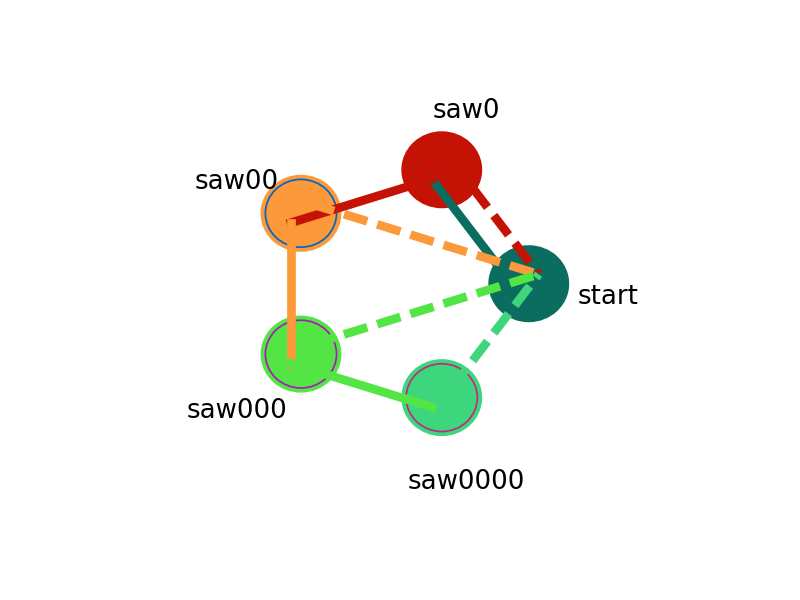

In [90]:
%matplotlib notebook
fsm.display()

In [87]:
min = fsm.minimize()

Nodes of pair graph:
['NODE_0 0', 'NODE_0 1', 'NODE_0 2', 'NODE_0 3', 'NODE_0 4', 'NODE_1 1', 'NODE_1 2', 'NODE_1 3', 'NODE_1 4', 'NODE_2 2', 'NODE_2 3', 'NODE_2 4', 'NODE_3 3', 'NODE_3 4', 'NODE_4 4']
Edges of pair graph: 
['EDGE__(1 1)->(0 0)', 'EDGE__(0 0)->(0 0)', 'EDGE__(1 2)->(0 1)', 'EDGE__(0 0)->(0 1)', 'EDGE__(1 3)->(0 2)', 'EDGE__(0 0)->(0 2)', 'EDGE__(1 4)->(0 3)', 'EDGE__(0 0)->(0 3)', 'EDGE__(1 4)->(0 4)', 'EDGE__(0 0)->(0 4)', 'EDGE__(2 2)->(1 1)', 'EDGE__(0 0)->(1 1)', 'EDGE__(2 3)->(1 2)', 'EDGE__(0 0)->(1 2)', 'EDGE__(2 4)->(1 3)', 'EDGE__(0 0)->(1 3)', 'EDGE__(2 4)->(1 4)', 'EDGE__(0 0)->(1 4)', 'EDGE__(3 3)->(2 2)', 'EDGE__(0 0)->(2 2)', 'EDGE__(3 4)->(2 3)', 'EDGE__(0 0)->(2 3)', 'EDGE__(3 4)->(2 4)', 'EDGE__(0 0)->(2 4)', 'EDGE__(4 4)->(3 3)', 'EDGE__(0 0)->(3 3)', 'EDGE__(4 4)->(3 4)', 'EDGE__(0 0)->(3 4)', 'EDGE__(4 4)->(4 4)', 'EDGE__(0 0)->(4 4)']


In [88]:
print(list(map(lambda x: str(x), min.nodes)))
print(list(map(lambda x: str(x), min.edges)))

['State_start_i-True_f-False', 'State_saw0_i-False_f-False', 'State_saw00_i-False_f-True']
['EDGE__(start)->(saw0)', 'EDGE__(start)->(start)', 'EDGE__(saw0)->(saw00)', 'EDGE__(saw0)->(start)', 'EDGE__(saw00)->(saw00)', 'EDGE__(saw00)->(start)']


<IPython.core.display.Javascript object>


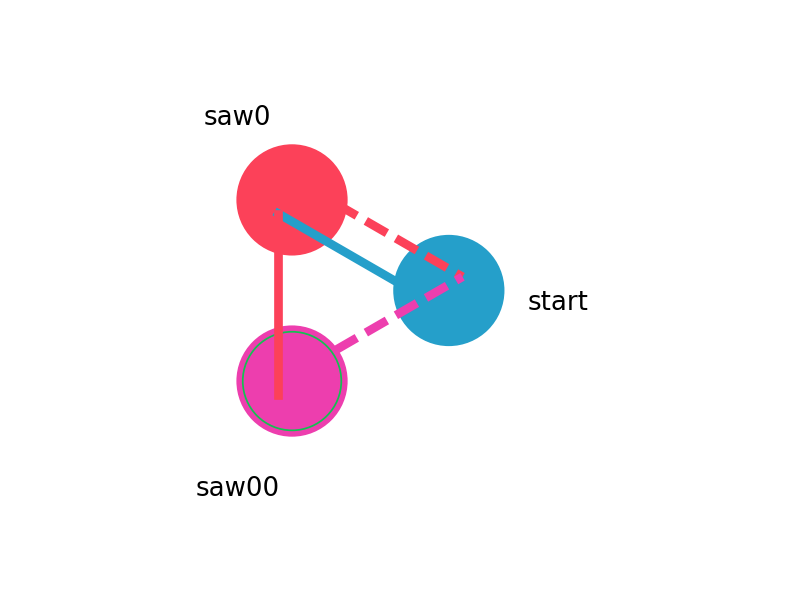

In [89]:
%matplotlib notebook
min.display()

In [80]:
min.toFile('divisibleby4MIN.fsm', 'Minimized version of the divisible by 4 FSM')